In [2]:
import fipy as fp

In [3]:
from fipy import numerix as nmx

In [34]:
dx = 1.
Lx = 96.
r0 = 8.

In [35]:
mesh = fp.Grid2D(dx=dx, Lx=Lx, dy=dx, Ly=Lx)

In [36]:
u = fp.CellVariable(mesh=mesh, name="u", hasOld=True)

In [37]:
phi = fp.CellVariable(mesh=mesh, name=r"$\varphi$", hasOld=True)

In [38]:
r = nmx.sqrtDot(mesh.cellCenters, mesh.cellCenters)

In [39]:
D = 10.
tau0 = 1.
W0 = 1.
lamda = D * tau0 / (0.6267 * W0**2)
norm = phi.grad / (phi.grad.mag + (phi.grad.mag == 0.) * 1.)
theta = nmx.arctan2(norm[1], norm[0])
theta.name = r"$\theta$"
m = fp.Variable(4)
epsilon = fp.Variable(0.05)
a = 1 + epsilon * nmx.cos(m * theta)
aPrime = -epsilon * nmx.sin(m * theta) * m
tau = tau0 * a**2
W = W0 * a
Wprime = W0 * aPrime
Dphi = W * (W * [[1, 0],
                 [0, 1]] + Wprime * [[0, -1],
                                     [1, 0]])
Delta = fp.Variable(value=0.3, name=r"$\Delta$")

In [40]:
u.constrain(-Delta, where=mesh.facesRight | mesh.facesTop)

In [41]:
m.value = 4

In [42]:
ueq = (fp.TransientTerm(coeff=1., var=u) 
       == fp.DiffusionTerm(coeff=D, var=u)
       + fp.TransientTerm(coeff=0.5, var=phi))

In [43]:
phieq = (fp.TransientTerm(coeff=tau, var=phi)
         == fp.DiffusionTerm(coeff=Dphi, var=phi)
         + fp.ImplicitSourceTerm(coeff=1-phi**2, var=phi)
         - fp.ImplicitSourceTerm(coeff=lamda * (1 - 2*phi**2 + phi**4), var=u))

In [44]:
eq = ueq & phieq

In [45]:
phi.value = -1
phi.setValue(+1, where=r <= r0)

In [46]:
u.value = -Delta

In [47]:
faceNorm = phi.faceGrad / (phi.faceGrad.mag + (phi.faceGrad.mag == 0.) * 1.)
faceNorm.name = r"$\hat{n}$"
curvature = faceNorm.divergence
curvature.name = r"$\kappa$"

In [48]:
radius = 1. / curvature
radius.name = r"$\rho$"

<Figure size 640x480 with 0 Axes>

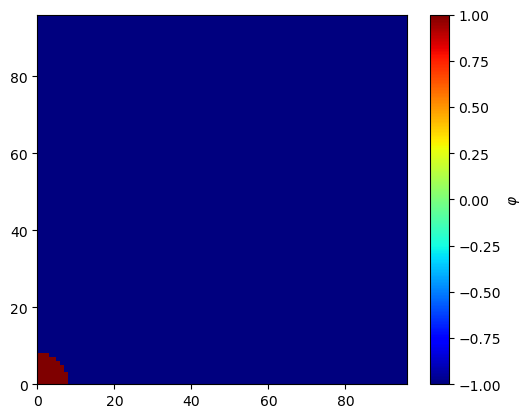

In [49]:
phiviewer = fp.Viewer(vars=phi, datamin=-1, datamax=1)

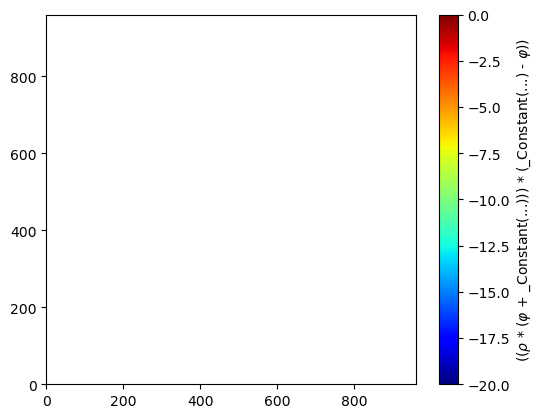

In [42]:
radviewer = fp.Viewer(vars=radius *(1 + phi) * (1-phi), datamin=-20, datamax=0)

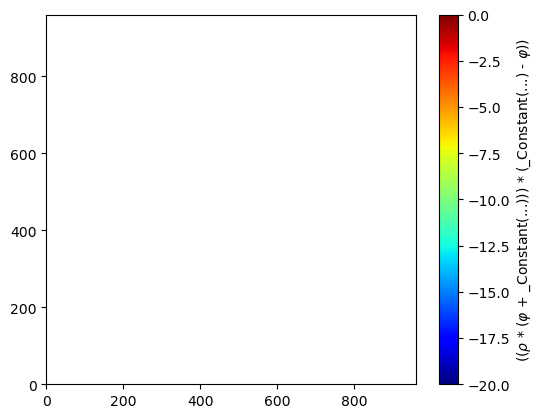

In [43]:
radviewer.plot()

In [83]:
fp.tools.dump.write(mesh, "mesh.gz")

In [84]:
tsv = fp.TSVViewer(vars=(phi, u))

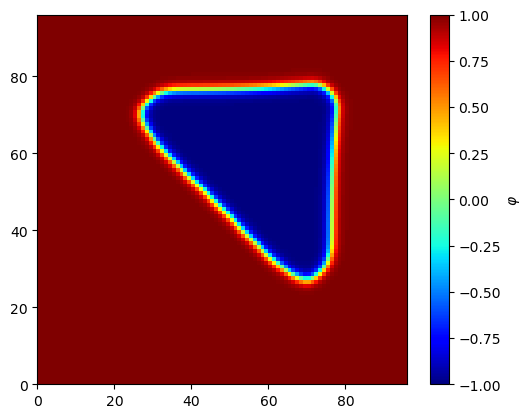

KeyboardInterrupt: 

In [50]:
for step in nmx.arange(15000):
    phi.updateOld()
    u.updateOld()
    for sweep in range(3):
        eq.sweep(dt=.1)
    if step % 10 == 0:
        phiviewer.plot()
    #     tsv.plot(filename="%d.txt.gz" % step)

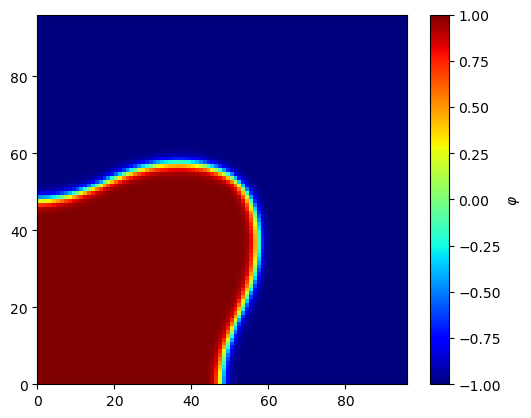

In [75]:
phiviewer.plot()

In [76]:
step

1530